# Importing important libraries

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import time
import random
from datetime import datetime
import shutil

In [17]:
# Image Data Generator
num_classes = 2
image_resize = 224
batch_size_training = 32
batch_size_validation = 32
input_shape = (image_resize, image_resize, 3)
num_epochs = 5
learning_rate = 0.01
class_1 = "cat"
class_2 = "dog"
train_percent = 0.80
val_percent = 1 - train_percent

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# TensorBoard and MLflow Logging
def create_experiment(class_1, class_2):
    experiment_name = f"{class_1}_{class_2}_classification"
    return experiment_name

def create_runname(model_name):
    run_name = datetime.now().strftime(f"{model_name}_%Y_%m_%d__%H%M%S")
    return run_name


In [18]:
experiment_name = create_experiment(class_1, class_2)
print(experiment_name)

cat_dog_classification


In [19]:
current_directory = os.getcwd()
image_path = "datasets/images"

In [20]:
train_dir = os.path.join(image_path, 'train')
val_dir = os.path.join(image_path, 'validation')

# Ensure directories exist
for directory in [train_dir, val_dir]:
    os.makedirs(os.path.join(directory, class_1), exist_ok=True)
    os.makedirs(os.path.join(directory, class_2), exist_ok=True)

def move_images(source_dir, dest_dir, num_images):
    images = os.listdir(source_dir)
    random.shuffle(images)
    for image in images[:num_images]:
        src_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        try:
            shutil.move(src_path, dest_path)
        except PermissionError as e:
            print(f"Permission error occurred: {e}. Skipping file: {src_path}")
        else:
            if dest_path.lower().endswith('.png'):
                try:
                    img = Image.open(dest_path)
                    if img.mode != 'RGBA':
                        img = img.convert('RGBA')
                        img.save(dest_path)
                except Exception as e:
                    print(f"Error converting {dest_path}: {e}")

def split_images(image_path, train_dir, val_dir, train_percent, val_percent):
    for category in [class_1, class_2]:
        source_category_dir = os.path.join(image_path, category)
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        num_images = len(os.listdir(source_category_dir))
        num_train = int(train_percent * num_images)
        num_val = int(val_percent * num_images)

        move_images(source_category_dir, train_category_dir, num_train)
        move_images(source_category_dir, val_category_dir, num_val)

split_images(image_path, train_dir, val_dir, train_percent, val_percent)
print("Images separated into train and validation directories successfully.")


Images separated into train and validation directories successfully.


In [21]:
# ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

In [22]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size_training,
    class_mode="categorical",
    shuffle=True
)

Found 19995 images belonging to 2 classes.


In [23]:
validation_generator = ImageDataGenerator().flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size_validation,
    class_mode="categorical",
    shuffle=True
)

Found 4998 images belonging to 2 classes.


In [24]:
# Adjust steps per epoch if necessary
steps_per_epoch_training = train_generator.samples // train_generator.batch_size
steps_per_epoch_validation = validation_generator.samples // validation_generator.batch_size

print(steps_per_epoch_training, steps_per_epoch_validation)

624 156


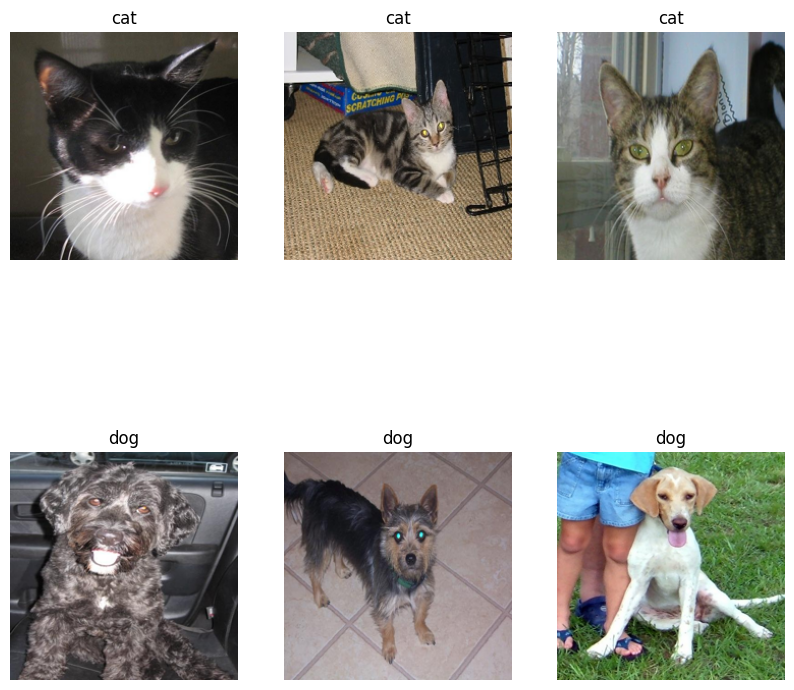

In [25]:
train_images = os.path.join(image_path, "train")
image_size = (image_resize, image_resize)

def display_images(directory):
    plt.figure(figsize=(10, 10))
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        images = [file for file in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, file))]
        for i in range(3):
            img_name = random.choice(images)
            img_path = os.path.join(category_dir, img_name)

            img = Image.open(img_path)
            img = img.resize(image_size)

            plt.subplot(2, 3, categories.index(category) * 3 + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.show()

display_images(train_images)

In [26]:
# Now, we need to prepare the data for Keras model training
def load_and_preprocess_data(image_path):
    X, y = [], []
    categories = [class_1, class_2]
    for category in categories:
        category_path = os.path.join(image_path, category)
        label = categories.index(category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            if os.path.isfile(img_path):
                img = Image.open(img_path)
                img = img.resize((image_resize, image_resize))
                img = np.array(img)
                if img.shape == (image_resize, image_resize, 3):  # Ensure all images are in the correct shape
                    X.append(img)
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y


In [27]:
X_train, y_train = load_and_preprocess_data(train_dir)
X_test, y_test = load_and_preprocess_data(val_dir)

# Normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Model definition and compilation
base_model = tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation
)
keras_training_time = time.time() - start_time

Epoch 1/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 391s 618ms/step - accuracy: 0.6311 - loss: 0.9512 - val_accuracy: 0.7376 - val_loss: 0.5190
Epoch 2/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - accuracy: 0.8125 - loss: 0.4637 - val_accuracy: 0.8333 - val_loss: 0.4602
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 308s 491ms/step - accuracy: 0.6936 - loss: 0.5759 - val_accuracy: 0.7506 - val_loss: 0.5075
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.7500 - loss: 0.5251 - val_accuracy: 0.8333 - val_loss: 0.5168
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 320s 511ms/step - accuracy: 0.7010 - loss: 0.5642 - val_accuracy: 0.7494 - val_loss: 0.5107


In [28]:
# Model evaluation
keras_accuracy = model.evaluate(validation_generator, steps=steps_per_epoch_validation)[1]

print(f"Keras training time: {keras_training_time} seconds")
print(f"Keras accuracy: {keras_accuracy}")



156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.7493 - loss: 0.5081
Keras training time: 1020.6038315296173 seconds
Keras accuracy: 0.7495993375778198


In [29]:
# Save the model in the new format
model.save('keras_mobilenet_model.keras', save_format='tf')


In [30]:
try:
    model = load_model('keras_mobilenet_model.keras')
    model.summary()
except Exception as e:
    print(f"Error loading model: {e}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,623,240 (13.82 MB)

 Trainable params: 131,458 (513.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 262,918 (1.00 MB)